# ***Packages***

In [1]:
# To ensure compatiblity of TensorFlow Addons with TensorFlow
!pip install tensorflow-addons[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 15.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [29]:
import os
import cv2
import time
import glob
import scipy
import random
import shutil
import pathlib
import zipfile
import requests
import datetime
import tifffile
import platform
import ipykernel
import itertools
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from skimage import io
import tensorflow as tf
from keras.models import *
from keras.layers import *
from IPython import display
from tensorflow import keras
from skimage import io, color
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from matplotlib.patches import Patch
from skimage.transform import resize
from skimage.io import imread, imsave
from keras.utils import to_categorical
from sklearn.utils import class_weight
from matplotlib.colors import Normalize
from skimage.util import view_as_windows
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model
from matplotlib.patches import Rectangle, Patch
from scipy.ndimage import distance_transform_edt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, UpSampling2D, Dropout, Activation, BatchNormalization, multiply, add

###### ***Ignore the errors***

# ***Dataset (downloading, extraction, organization)***

In [3]:
# Function to download the dataset
def download_file(url, dest):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte
    with open(dest, 'wb') as file, tqdm(
        desc="Downloading zip file",
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            bar.update(len(data))
            file.write(data)

# Function to extract the zip file
def extract_zip_with_progress(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        total_files = len(zip_ref.infolist())
        with tqdm(total=total_files, desc="Extracting zip file") as pbar:
            for file in zip_ref.infolist():
                zip_ref.extract(file, extract_to)
                pbar.update(1)

# Function to organize, resize, and sorte images
def resize_and_save(src_dir, dst_dir_a, dst_dir_b, size=(512, 512)):
    files = sorted(os.listdir(src_dir))
    half_index = len(files) // 2  # Calculate the split index
    with tqdm(total=len(files), desc=f"Resizing (624*624 -> 512*512) and saving files from {src_dir}") as pbar:
        for i, filename in enumerate(files):
            if filename.endswith('.png'):
                img_path = os.path.join(src_dir, filename)
                img = Image.open(img_path)
                new_img = img.resize(size)
                if i < half_index:
                    new_img.save(os.path.join(dst_dir_a, filename))
                else:
                    new_img.save(os.path.join(dst_dir_b, filename))
                pbar.update(1)

# "The dataset is available from Liang et al. (2021) at the following link: https://doi.org/10.5281/zenodo.4722095."
# or
# "The dataset is available from Liang et al. (2022) at the following link: https://doi.org/10.1016/j.cageo.2022.105217"

# Download the zip file
url = "https://zenodo.org/records/4722095/files/Bent_data_624.zip?download=1"
zip_path = "/kaggle/working/Bent_data_624.zip"
download_file(url, zip_path)

# Extract the zip file
extract_zip_with_progress(zip_path, "/kaggle/working/")

# Remove the zip file
os.remove(zip_path)
print("Zip file removed")

# Define source and destination paths
source_dir = "/kaggle/working/Bent_data_624"
sample_c_inputs = "/kaggle/working/sample_c/inputs"
sample_c_labels = "/kaggle/working/sample_c/labels"
sample_a_inputs = "/kaggle/working/sample_a/inputs"
sample_a_labels = "/kaggle/working/sample_a/labels"
sample_b_inputs = "/kaggle/working/sample_b/inputs"
sample_b_labels = "/kaggle/working/sample_b/labels"

# Create destination directories
os.makedirs(sample_c_inputs, exist_ok=True)
os.makedirs(sample_c_labels, exist_ok=True)
os.makedirs(sample_a_inputs, exist_ok=True)
os.makedirs(sample_a_labels, exist_ok=True)
os.makedirs(sample_b_inputs, exist_ok=True)
os.makedirs(sample_b_labels, exist_ok=True)

# Resize and move files
resize_and_save(os.path.join(source_dir, "image_test"), sample_c_inputs, sample_c_inputs)
resize_and_save(os.path.join(source_dir, "mask_test"), sample_c_labels, sample_c_labels)
resize_and_save(os.path.join(source_dir, "image_train_valid_XYZ"), sample_a_inputs, sample_b_inputs)
resize_and_save(os.path.join(source_dir, "mask_train_valid_XYZ"), sample_a_labels, sample_b_labels)

# Delete the old folder
shutil.rmtree(source_dir)
print("Old folder deleted")

print("All files have been organized, resized, and sorted")

Extracting zip file: 100%|██████████| 11236/11236 [00:04<00:00, 2571.91it/s]


Zip file removed


Resizing (624*624 -> 512*512) and saving files from /kaggle/working/Bent_data_624/image_test: 100%|██████████| 1872/1872 [00:58<00:00, 32.01it/s]
Resizing (624*624 -> 512*512) and saving files from /kaggle/working/Bent_data_624/mask_test: 100%|██████████| 1872/1872 [00:26<00:00, 72.00it/s]
Resizing (624*624 -> 512*512) and saving files from /kaggle/working/Bent_data_624/image_train_valid_XYZ: 100%|██████████| 3744/3744 [02:51<00:00, 21.85it/s]
Resizing (624*624 -> 512*512) and saving files from /kaggle/working/Bent_data_624/mask_train_valid_XYZ: 100%|██████████| 3744/3744 [00:53<00:00, 70.34it/s]


Old folder deleted
All files have been organized, resized, and sorted


## ***Train & validation data prepration***

### ***Sample A, 20 uCT slices***

#### ***Inputs***

In [4]:
# The path of input images of sample A
folder_path = "/kaggle/working/sample_a/inputs/"

# Listing all the image files in the folder and sorting them by name
files = os.listdir(folder_path)
image_files = sorted([f for f in files if f.endswith(".png")])

# Determining the step size to use for selecting images (100 steps in this case, including the first & last ones)
step = int(len(image_files) / (len(image_files) * 0.01) + 1)

# Selecting the images
selected_images = []
for i in range(0, len(image_files), step):
    selected_images.append(image_files[i])
selected_images = list(set(selected_images))
selected_images.sort()

# The first and last images must be included in the selection
if image_files[0] not in selected_images:
    selected_images.insert(0, image_files[0])
if image_files[-1] not in selected_images:
    selected_images.append(image_files[-1])

# Move the selected images to a new folder
new_folder_path = "/kaggle/working/train_val_inputs/100step/"
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
for image_file in selected_images:
    shutil.copy(os.path.join(folder_path, image_file), new_folder_path)

print(f"Selected and copied {len(selected_images)} images to {new_folder_path}")

Selected and copied 20 images to /kaggle/working/train_val_inputs/100step/


#### ***Labels***

In [5]:
# The path of label images of sample A
folder_path = "/kaggle/working/sample_a/labels/"

# Listing all the image files in the folder and sorting them by name
files = os.listdir(folder_path)
image_files = sorted([f for f in files if f.endswith(".png")])

# Determining the step size to use for selecting images (100 steps in this case, including the first & last ones)
step = int(len(image_files) / (len(image_files) * 0.01) + 1)

# Selecting the images
selected_images = []
for i in range(0, len(image_files), step):
    selected_images.append(image_files[i])
selected_images = list(set(selected_images))
selected_images.sort()

# The first and last images must be included in the selection
if image_files[0] not in selected_images:
    selected_images.insert(0, image_files[0])
if image_files[-1] not in selected_images:
    selected_images.append(image_files[-1])

# Move the selected images to a new folder
new_folder_path = "/kaggle/working/train_val_labels/100step/"
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
for image_file in selected_images:
    shutil.copy(os.path.join(folder_path, image_file), new_folder_path)

print(f"Selected and copied {len(selected_images)} images to {new_folder_path}")

Selected and copied 20 images to /kaggle/working/train_val_labels/100step/


### ***Sample B, 20 uCT slices***

#### ***Inputs***

In [6]:
# The path of input images of sample B
folder_path = "/kaggle/working/sample_b/inputs/"

# Listing all the image files in the folder and sorting them by name
files = os.listdir(folder_path)
image_files = sorted([f for f in files if f.endswith(".png")])

# Determining the step size to use for selecting images (100 steps in this case, including the first & last ones)
step = int(len(image_files) / (len(image_files) * 0.01) + 1)

# Selecting the images
selected_images = []
for i in range(0, len(image_files), step):
    selected_images.append(image_files[i])
selected_images = list(set(selected_images))
selected_images.sort()

# The first and last images must be included in the selection
if image_files[0] not in selected_images:
    selected_images.insert(0, image_files[0])
if image_files[-1] not in selected_images:
    selected_images.append(image_files[-1])

# Move the selected images to a new folder
new_folder_path = "/kaggle/working/train_val_inputs/100step/"
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
for image_file in selected_images:
    shutil.copy(os.path.join(folder_path, image_file), new_folder_path)

print(f"Selected and copied {len(selected_images)} images to {new_folder_path}")

Selected and copied 20 images to /kaggle/working/train_val_inputs/100step/


#### ***Labels***

In [7]:
# The path of input images of sample B
folder_path = "/kaggle/working/sample_b/labels/"

# Listing all the image files in the folder and sorting them by name
files = os.listdir(folder_path)
image_files = sorted([f for f in files if f.endswith(".png")])

# Determining the step size to use for selecting images (100 steps in this case, including the first & last ones)
step = int(len(image_files) / (len(image_files) * 0.01) + 1)

# Selecting the images
selected_images = []
for i in range(0, len(image_files), step):
    selected_images.append(image_files[i])
selected_images = list(set(selected_images))
selected_images.sort()

# The first and last images must be included in the selection
if image_files[0] not in selected_images:
    selected_images.insert(0, image_files[0])
if image_files[-1] not in selected_images:
    selected_images.append(image_files[-1])

# Move the selected images to a new folder
new_folder_path = "/kaggle/working/train_val_labels/100step/"
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
for image_file in selected_images:
    shutil.copy(os.path.join(folder_path, image_file), new_folder_path)

print(f"Selected and copied {len(selected_images)} images to {new_folder_path}")

Selected and copied 20 images to /kaggle/working/train_val_labels/100step/


### ***2in1 (input_label)***

In [8]:
# Path to input and label folders
input_folder = "/kaggle/working/train_val_inputs/100step/"
mask_folder = "/kaggle/working/train_val_labels/100step/"

# Create a folder for the combined images
gan_folder = "/kaggle/working/train_val_data/100step/"
os.makedirs(gan_folder, exist_ok=True)

# Get sorted lists of files in each folder
input_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.png')])
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png')])

# Verify that both folders contain the same number of files
if len(input_files) != len(mask_files):
    raise ValueError("The number of input files and mask files do not match.")

# Loop through the 40
for i in range(min(40, len(input_files))):
    input_image_path = os.path.join(input_folder, input_files[i])
    mask_image_path = os.path.join(mask_folder, mask_files[i])

    # Read the images in grayscale
    input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    mask_image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)

    # Check if both images are successfully loaded
    if input_image is None or mask_image is None:
        print(f"Error loading images at index {i}: {input_image_path} or {mask_image_path}")
        continue

    # Combine input and label images horizontally
    combined_image = cv2.hconcat([input_image, mask_image])

    # Save combined image to a folder
    combined_image_path = os.path.join(gan_folder, f"Bentheimer_{i:04d}.png")
    cv2.imwrite(combined_image_path, combined_image)

shutil.rmtree("/kaggle/working/train_val_inputs")
shutil.rmtree("/kaggle/working/train_val_labels")
print(f"Processed {min(40, len(input_files))} images.")

Processed 40 images.


## ***Train & validation data preprocessing, augmentation and generators***

In [9]:
# Get the list of file paths for input images
file_paths = tf.data.Dataset.list_files("/kaggle/working/train_val_data/100step/*.png")

# Convert the dataset to a list
file_paths = list(file_paths.as_numpy_iterator())

train_dataset = tf.data.Dataset.from_tensor_slices(file_paths)

In [10]:
# Defining load function
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_png(image)

  # Split each image tensor into two tensors
  w = tf.shape(image)[1]
  w = w // 2
  input = image[:, :w, :]
  label = image[:, w:, :]

  # Convert images to float16 tensors
  input = tf.cast(input, tf.float32)
  label = tf.cast(label, tf.float32)

  return input, label

# Defining normalize function
def normalize(input, label):
    
  # Normalize the input image by scaling its pixel values to the range [-1, 1]
  input = (input / 127.5) - 1
  
  # Normalize the label image by scaling its pixel values to the range [-1, 1]
  label = (label - 1.5) * (2/3)
    
  # Return the normalized input and label images
  return input, label

# Defining resize function
def r_size(input, label, height, width):
    
  # Resize the input image to the desired height and width using nearest neighbor interpolation
  input = tf.image.resize(input, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
  # Resize the label image to the desired height and width using nearest neighbor interpolation
  label = tf.image.resize(label, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
  # Return the resized input and real images
  return input, label

# Each image is 512x512 in size
IMG_WIDTH = 512
IMG_HEIGHT = 512

# Defining random_crop function
def random_crop(input, label):
    
  # Stack the input and real images along the first dimension
  stacked_image = tf.stack([input, label], axis=0)
    
  # Randomly crop the stacked image to the desired size
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_WIDTH, IMG_HEIGHT, 1])
    
  # Return the cropped input and label images
  return cropped_image[0], cropped_image[1]

# Defining random_shear function
def random_shear(input, label, shear_range):
    shear_factor = tf.random.uniform([], minval=-shear_range, maxval=shear_range)
    transformed_input = tfa.image.transform(input, [1.0, shear_factor, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], fill_mode='reflect')
    transformed_label = tfa.image.transform(label, [1.0, shear_factor, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], fill_mode='reflect')
    return transformed_input, transformed_label

# Defining random_zoom function
def random_zoom(input, label, zoom_range):
    zoom_factor = tf.random.uniform([], minval=0.0, maxval=zoom_range) + 1.0
    zoom_factor = tf.cast(zoom_factor, input.dtype)
    cropped_height = tf.cast(tf.shape(input)[0], tf.float32) / zoom_factor
    cropped_width = tf.cast(tf.shape(input)[1], tf.float32) / zoom_factor
    central_fraction = tf.minimum(cropped_height / tf.cast(tf.shape(input)[0], tf.float32),
                                  cropped_width / tf.cast(tf.shape(input)[1], tf.float32))
    
    cropped_input = tf.image.central_crop(input, central_fraction)
    resized_input = tf.image.resize(cropped_input, tf.shape(input)[:2])
    
    cropped_label = tf.image.central_crop(label, central_fraction)
    resized_label = tf.image.resize(cropped_label, tf.shape(label)[:2])
    
    return resized_input, resized_label

# Defining random_jitter function
@tf.function()
def random_jitter(input, label):
  
  # Resize the input and label images to (512+30)x(512+30)
  input, label = r_size(input, label, IMG_WIDTH+30, IMG_WIDTH+30)

  # Randomly crop the input and label images to 512x512
  input, label = random_crop(input, label)

  # Randomly flip the images left to right with 50% probability
  if tf.random.uniform(()) > 0.5:
    input = tf.image.flip_left_right(input)
    label = tf.image.flip_left_right(label)

  # Randomly flip the images up & down with 50% probability
  if tf.random.uniform(()) > 0.5:
    input = tf.image.flip_up_down(input)
    label = tf.image.flip_up_down(label)
    
  # Randomly rotate the images with 50% probability
  if tf.random.uniform(()) > 0.5:
    input = tfa.image.rotate(input, tf.constant(np.pi/9), 'nearest', fill_mode='reflect')
    label = tfa.image.rotate(label, tf.constant(np.pi/9), 'nearest', fill_mode='reflect')
    
  # Randomly zoom the images with 50% probability
  if tf.random.uniform(()) > 0.5:
    input, label = random_zoom(input, label, 0.1) 

  # Randomly shear the images with 50% probability
  if tf.random.uniform(()) > 0.5:
    input, label = random_shear(input, label, 0.1)
    
  # Return the randomly jittered input and label images
  return input, label

# Defining preparing function
def preparing(input, label):
    
  # Apply random jitter to the images
  input, label = random_jitter(input, label)

  # Return the preprocessed images
  return input, label

# Defining preparing training data function
def prep_train(image_file):
  # Load the input and label images from the given image file
  input, label = load(image_file)
    
  # Normalize the input and label images
  input, label = normalize(input, label)
    
  # Preparing the  images
  input, label = preparing(input, label)
        
  # Return the prepared images
  return input, label

# Defining preparing validation data function
def prep_val(image_file):
  # Split the images from the given image file
  input, label = load(image_file)
    
  # Normalize the images
  input, label = normalize(input, label)
    
  # Return the prepared images
  return input, label

In [11]:
# Defining generators
def generator(file_paths, batch_size, split_ratio, validation=False):
    while True:
        random.shuffle(file_paths)

        train_paths = file_paths[:int(split_ratio * len(file_paths))]
        val_paths = file_paths[int(split_ratio * len(file_paths)):]

        try:
            train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
        except tf.errors.InvalidArgumentError:
            train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
        train_dataset = train_dataset.map(prep_train)
        train_dataset = train_dataset.batch(batch_size)

        try:
            val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
        except tf.errors.InvalidArgumentError:
            val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
        val_dataset = val_dataset.map(prep_val)
        val_dataset = val_dataset.batch(batch_size)

        if not validation:
            for input, label in train_dataset:
                
                # [0 ,1]
                input = (input + 1) / 2.0
                input = np.array(input)
                
                # [0 ,3]
                label = (label * 3/2) + 1.5
                label = np.round(np.clip(label, 0, 3))
                
                label = to_categorical(
                    label, num_classes=4)[:, :, :, 0:]

                yield input, label

        else:
            for input, label in val_dataset:
                
                # [0, 1]
                input = (input + 1) / 2.0
                input = np.array(input)
                
                # [0 ,3]
                label = (label * 3/2) + 1.5
                label = np.round(np.clip(label, 0, 3))
                
                label = to_categorical(
                    label, num_classes=4)[:, :, :, 0:]

                yield input, label
                
train_generator = generator(file_paths, 8, 0.8, validation=False)
val_generator = generator(file_paths, 8, 0.8, validation=True)

# ***U-Net***

In [12]:
# Defining weighted f1 score function
def weighted_f1(y_true, y_pred):
    """
    Weighted F1 score metric function for Keras model
    """
    # Convert predictions to binary values
    y_pred = K.round(y_pred)

    # Calculate true positives, false positives, and false negatives for each class
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    # Calculate precision and recall for each class
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate F1 score for each class
    f1_score = 2 * precision * recall / (precision + recall + K.epsilon())

    # Calculate class weights based on their frequency in the dataset
    class_weights = K.sum(y_true, axis=0) / K.sum(y_true)

    # Calculate weighted F1 score
    weighted_f1_score = K.sum(class_weights * f1_score)

    return weighted_f1_score

In [13]:
# Optimizer
optimizer = Adam(learning_rate=1e-3)

# Define the convolutional block
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    
    # first layer
    x1 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                kernel_initializer="he_uniform", # glorot_uniform or he_uniform
                dilation_rate=(1, 1), padding="same", kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(input_tensor)
    if batchnorm:
        x1 = BatchNormalization()(x1)
        x1 = Activation("relu")(x1) # relu, elu, selu
        
    # second layer
    x = Conv2D(filters=n_filters*1, kernel_size=(kernel_size, kernel_size),
               kernel_initializer="he_uniform", # glorot_uniform or he_uniform
               dilation_rate=(1, 1), padding="same", kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4))(x1)
    if batchnorm:
        x = BatchNormalization()(x)  
    x = Activation("relu")(x) # relu, elu, selu
    return x

# Define the model architecture
def model(input_img, n_filters=16, batchnorm=True):
    
    # Encoding Path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
 
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
        
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    # Bottom
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # Decoding Path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), dilation_rate=(1, 1), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), dilation_rate=(1, 1), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), dilation_rate=(1, 1), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), dilation_rate=(1, 1), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    # Classifier part
    outputs = Conv2D(4, (1, 1), activation='softmax') (c9) # softmax or sigmoid?
    
    # Define the model
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Define the input shape
input_img = Input((512, 512, 1))

# Get the model
def get_model():
    return model(input_img, n_filters=16, batchnorm=True)

model = get_model()

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', weighted_f1])

In [14]:
# Instantiate custom callbacks

# 1 Define a callback to reduce learning rate for a specific situation
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-5, verbose=2)

# 2 Define a callback to stop training process for a specific situation
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=1e-4, patience=8)

# 3 Define a callback to save history logs
csvl = CSVLogger("./history_log.csv", append=True)

# 4 Define a callback to save the best weights
checkpoint_dir = "./weights/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_filepath = os.path.join(checkpoint_dir, "best_weights.hdf5")
chp = ModelCheckpoint(checkpoint_filepath, monitor='loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto')

# ***Train & validation***

In [15]:
# Training & validation procedure
nb_epoch = 1000
batch_size = 1

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=1.6*len(file_paths) // batch_size,
    
    validation_data=val_generator,
    validation_steps=0.4*len(file_paths) // batch_size,
    
    epochs=nb_epoch, verbose=1,
        
    callbacks=[ # Setting callbacks
        csvl,
        rlr,
        chp,
        es
    ]
    
)

Epoch 1/1000


I0000 00:00:1718946982.560205     141 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - ETA: 0s - loss: 1.0305 - accuracy: 0.8414 - weighted_f1: 0.3162
Epoch 1: loss improved from inf to 1.03053, saving model to ./weights/best_weights.hdf5
64/64 [==============================] - 48s 418ms/step - loss: 1.0305 - accuracy: 0.8414 - weighted_f1: 0.3162 - val_loss: 2.5318 - val_accuracy: 0.1099 - val_weighted_f1: 0.0458 - lr: 0.0010
Epoch 2/1000
64/64 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.9470 - weighted_f1: 0.8820
Epoch 2: loss improved from 1.03053 to 0.54327, saving model to ./weights/best_weights.hdf5
64/64 [==============================] - 26s 409ms/step - loss: 0.5433 - accuracy: 0.9470 - weighted_f1: 0.8820 - val_loss: 0.6750 - val_accuracy: 0.8730 - val_weighted_f1: 0.8101 - lr: 0.0010
Epoch 3/1000
64/64 [==============================] - ETA: 0s - loss: 0.3195 - accuracy: 0.9584 - weighted_f1: 0.9464
Epoch 3: loss improved from 0.54327 to 0.31945, saving model to ./weights/best_weights.hdf5
6

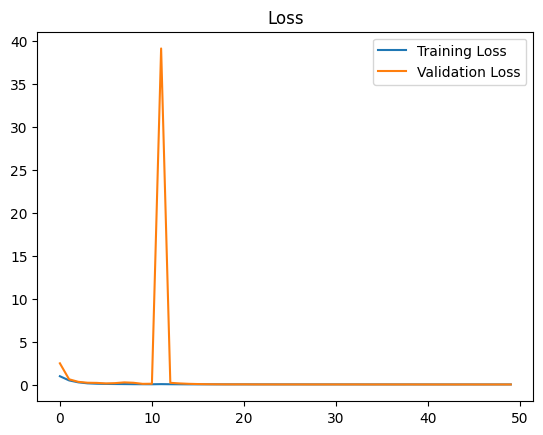

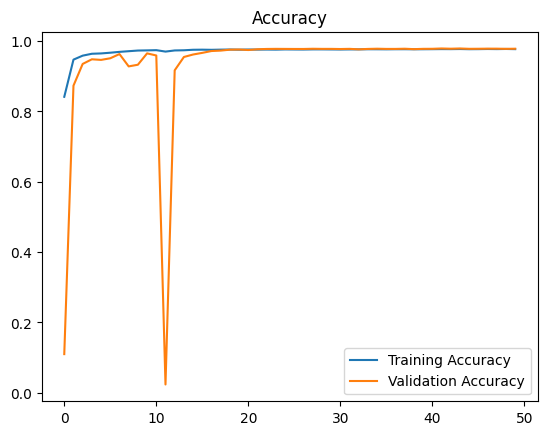

In [16]:
# Get the history of training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Plot the accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# ***Evaluation & blind test***

In [24]:
# Due to RAM limits
import gc
gc.collect()

0

## ***Load the best weight***

In [17]:
model.load_weights('/kaggle/working/weights/best_weights.hdf5')

## ***Preparing blind test sample c (also a & b)***

In [18]:
# Sample c (modify for evaluation of a & b)
input_dir = '/kaggle/working/sample_c/inputs/'
mask_dir = '/kaggle/working/sample_c/labels/'

input_images = io.imread_collection(os.path.join(input_dir, '*.png'))
mask_images = io.imread_collection(os.path.join(mask_dir, '*.png'))

In [19]:
# Inputs
x_test = []
for img in input_images:
    img_norm = img.astype('float16') / 255.0
    x_test.append(img_norm)
x_test = np.array(x_test)

In [20]:
# Labels
y_test = []
for img in mask_images:
    img_onehot = to_categorical(img, num_classes=4)[:, :, 0:] # The background class (0) is excluded
    y_test.append(img_onehot)
y_test = np.array(y_test)
y_test = y_test.astype('float16')

In [21]:
# Saving path
test_dir = "/kaggle/working/test_data/"
if not os.path.exists(test_dir):
    os.makedirs(test_dir)
# Save the arrays
np.save(test_dir + '/x_test.npy', x_test)
np.save(test_dir + '/y_test.npy', y_test)

In [23]:
x_test = np.load(test_dir + '/x_test.npy')

batch_size = 100
y_pred = []
for i in range(0, len(x_test), batch_size):
    batch_x_test = x_test[i:i+batch_size]
    batch_y_pred = model.predict(batch_x_test)
    y_pred.append(batch_y_pred)
    print(i)
y_pred = np.concatenate(y_pred, axis=0)

del x_test

4/4 [==============================] - 12s 794ms/step
0
4/4 [==============================] - 1s 196ms/step
100
4/4 [==============================] - 1s 196ms/step
200
4/4 [==============================] - 1s 196ms/step
300
4/4 [==============================] - 1s 196ms/step
400
4/4 [==============================] - 1s 195ms/step
500
4/4 [==============================] - 1s 196ms/step
600
4/4 [==============================] - 1s 196ms/step
700
4/4 [==============================] - 1s 196ms/step
800
4/4 [==============================] - 1s 196ms/step
900
4/4 [==============================] - 1s 196ms/step
1000
4/4 [==============================] - 1s 196ms/step
1100
4/4 [==============================] - 1s 196ms/step
1200
4/4 [==============================] - 1s 196ms/step
1300
4/4 [==============================] - 1s 196ms/step
1400
4/4 [==============================] - 1s 196ms/step
1500
4/4 [==============================] - 1s 196ms/step
1600
4/4 [====================

## ***Evaluation metrics***

### ***Pore***

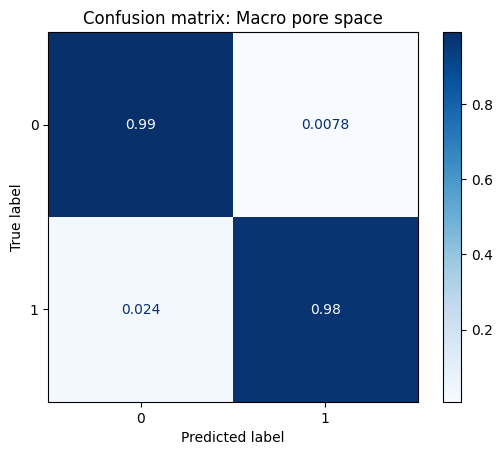

Accuracy: 0.9840735840097752
Precision: 0.9759399605359057
Recall: 0.9920783439484184
F1-Score: 0.9839429822734742
Intersection over Union (IoU): 0.9683934711411097


In [25]:
# Compute confusion matrix for 1st class
y_test = np.load(test_dir + '/y_test.npy')
true = np.argmax(y_test, axis=-1) == 0
del y_test

pred = np.argmax(y_pred, axis=-1) == 0

cm = confusion_matrix(true.ravel(), pred.ravel())

# Normalize confusion matrix by true class frequencies
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp.plot(cmap = 'Blues')
disp.ax_.set_title('Confusion matrix: Macro pore space')
plt.show()

accuracy = (cm_norm[0, 0] + cm_norm[1, 1]) / np.sum(cm_norm)

Precision = cm_norm[1][1] / (cm_norm[1][1] + cm_norm[1][0])
Recall = cm_norm[1][1] / (cm_norm[1][1] + cm_norm[0][1])
F1 = 2 * (Precision * Recall) / (Precision + Recall)
iou = cm_norm[1, 1] / (cm_norm[1, 1] + cm_norm[0, 1] + cm_norm[1, 0])

print('Accuracy:', accuracy)
print('Precision:', Precision)
print('Recall:', Recall)
print('F1-Score:', F1)
print('Intersection over Union (IoU):', iou)

### ***Quartz***

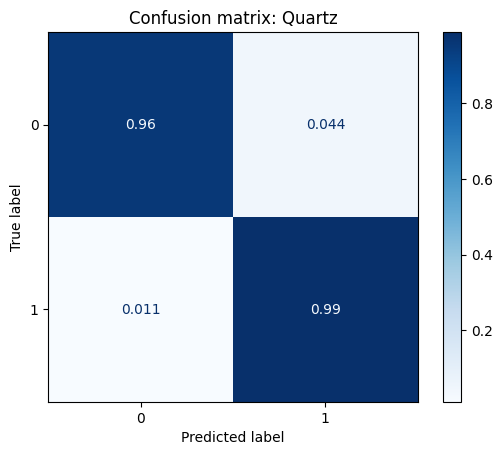

Accuracy: 0.9722133787991701
Precision: 0.9887357293929531
Recall: 0.9571083693245064
F1-Score: 0.9726650169722301
Intersection over Union (IoU): 0.9467846739780864


In [26]:
# Compute confusion matrix for 2nd class
y_test = np.load(test_dir + '/y_test.npy')
true = np.argmax(y_test, axis=-1) == 1
del y_test

pred = np.argmax(y_pred, axis=-1) == 1

cm = confusion_matrix(true.ravel(), pred.ravel())

# Normalize confusion matrix by true class frequencies
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp.plot(cmap = 'Blues')
disp.ax_.set_title('Confusion matrix: Quartz')
plt.show()

accuracy = (cm_norm[0, 0] + cm_norm[1, 1]) / np.sum(cm_norm)

Precision = cm_norm[1][1] / (cm_norm[1][1] + cm_norm[1][0])
Recall = cm_norm[1][1] / (cm_norm[1][1] + cm_norm[0][1])
F1 = 2 * (Precision * Recall) / (Precision + Recall)
iou = cm_norm[1, 1] / (cm_norm[1, 1] + cm_norm[0, 1] + cm_norm[1, 0])

print('Accuracy:', accuracy)
print('Precision:', Precision)
print('Recall:', Recall)
print('F1-Score:', F1)
print('Intersection over Union (IoU):', iou)

### ***Clay***

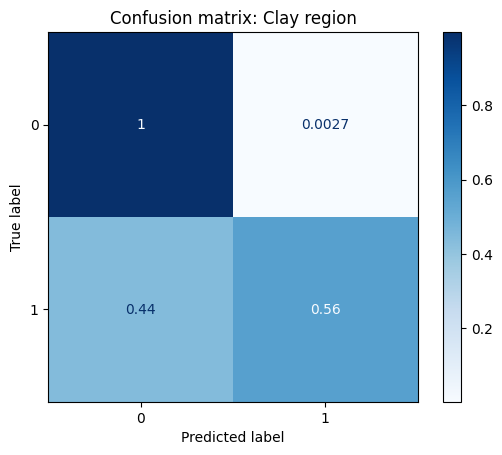

Accuracy: 0.7780385552477268
Precision: 0.5587376777102632
Recall: 0.995260820212994
F1-Score: 0.7156888763341418
Intersection over Union (IoU): 0.5572550631589358


In [27]:
# Compute confusion matrix for 3rd class
y_test = np.load(test_dir + '/y_test.npy')
true = np.argmax(y_test, axis=-1) == 2
del y_test

pred = np.argmax(y_pred, axis=-1) == 2

cm = confusion_matrix(true.ravel(), pred.ravel())

# Normalize confusion matrix by true class frequencies
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp.plot(cmap = 'Blues')
disp.ax_.set_title('Confusion matrix: Clay region')
plt.show()

accuracy = (cm_norm[0, 0] + cm_norm[1, 1]) / np.sum(cm_norm)

Precision = cm_norm[1][1] / (cm_norm[1][1] + cm_norm[1][0])
Recall = cm_norm[1][1] / (cm_norm[1][1] + cm_norm[0][1])
F1 = 2 * (Precision * Recall) / (Precision + Recall)
iou = cm_norm[1, 1] / (cm_norm[1, 1] + cm_norm[0, 1] + cm_norm[1, 0])

print('Accuracy:', accuracy)
print('Precision:', Precision)
print('Recall:', Recall)
print('F1-Score:', F1)
print('Intersection over Union (IoU):', iou)

### ***Feldspar***

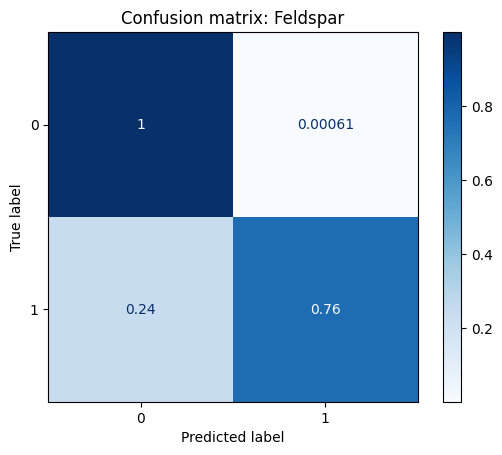

Accuracy: 0.8819546383206753
Precision: 0.7645206879104713
Recall: 0.9992009075690639
F1-Score: 0.8662475610361509
Intersection over Union (IoU): 0.7640535369677578


In [28]:
# Compute confusion matrix for 4th class
y_test = np.load(test_dir + '/y_test.npy')
true = np.argmax(y_test, axis=-1) == 3
del y_test

pred = np.argmax(y_pred, axis=-1) == 3

cm = confusion_matrix(true.ravel(), pred.ravel())

# Normalize confusion matrix by true class frequencies
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp.plot(cmap = 'Blues')
disp.ax_.set_title('Confusion matrix: Feldspar')
plt.show()

accuracy = (cm_norm[0, 0] + cm_norm[1, 1]) / np.sum(cm_norm)

Precision = cm_norm[1][1] / (cm_norm[1][1] + cm_norm[1][0])
Recall = cm_norm[1][1] / (cm_norm[1][1] + cm_norm[0][1])
F1 = 2 * (Precision * Recall) / (Precision + Recall)
iou = cm_norm[1, 1] / (cm_norm[1, 1] + cm_norm[0, 1] + cm_norm[1, 0])

print('Accuracy:', accuracy)
print('Precision:', Precision)
print('Recall:', Recall)
print('F1-Score:', F1)
print('Intersection over Union (IoU):', iou)

In [ ]:
slide_number = 0

# Load inputs and labels
x_test = np.load('/kaggle/working/test_data/x_test.npy')[slide_number]
y_test = np.argmax(np.load('/kaggle/working/test_data/y_test.npy')[slide_number], axis=-1)
y_pred0 = np.argmax(y_pred[slide_number], axis=-1)

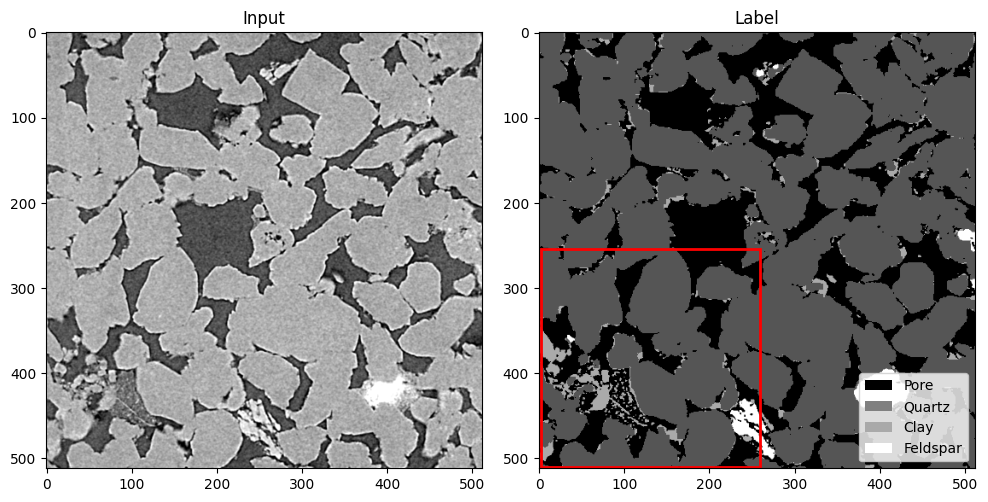

In [30]:
# Function to plot
def plot_input_and_label(x_test, y_test, cmap='gray'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(x_test, cmap=cmap)
    axes[0].set_title("Input")

    axes[1].imshow(y_test, cmap=cmap)
    axes[1].set_title("Label")

    # Legend for the Label image
    legend_labels = [Patch(facecolor='black', label='Pore'),
                    Patch(facecolor='gray', label='Quartz'),
                    Patch(facecolor='darkgray', label='Clay'),
                    Patch(facecolor='white', label='Feldspar')]
    axes[1].legend(handles=legend_labels, loc='lower right', fontsize=10)
    
    # Add rectangle to the "Label" plot i.e., axes[1]
    rect = Rectangle((2, y_test.shape[0] - 258), 257, 256, linewidth=2, edgecolor='r', facecolor='none')
    axes[1].add_patch(rect)
    
    plt.tight_layout()
    plt.show()
    
plot_input_and_label(x_test, y_test)

In [ ]:
def plot_predictions_and_errors(x_test, y_test, y_pred, index=0):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Normalize
    norm = Normalize(vmin=0, vmax=1)
    
    # Plot Input
    axes[0].imshow(x_test[256:512, :256], cmap='gray')
    axes[0].set_title("Input")
    
    # Plot Label
    axes[1].imshow(y_test[256:512, :256], cmap='gray')
    axes[1].set_title("True Label")
    
    # Plot Prediction
    axes[2].imshow(y_pred0[256:512, :256], cmap='gray')
    axes[2].set_title("Prediction")
    
    # Plot Error Map
    error_map = np.abs(y_pred0 - y_test)
    error_map = np.where(error_map > 0, 1, 0)
    axes[3].imshow(error_map[256:512, :256], cmap='gray')
    axes[3].set_title("Error Map")
    
    plt.tight_layout()
    plt.show()

plot_predictions_and_errors(x_test, y_test, y_pred, index=0)